# Exploratory data analysis

In [4]:
# Import Libraries and Load Data
import pandas as pd
import matplotlib.pyplot as plt
import os

# Configuration
# IMPORTANT: Make sure your notebook is in the 'analysis' folder,
# so the relative path '../data/' points correctly to your data folder.
DATA_DIR = '../data/raw/'

# Load Power Grid Data
# List all the 15-minute data files
load_files = [
    'germany_2015_15min.csv', 'germany_2016_15min.csv', 'germany_2017_15min.csv',
    'germany_2018_15min.csv', 'germany_2019_15min.csv', 'germany_2020_15min.csv',
    'germany_2021_15min.csv', 'germany_2022_15min.csv', 'germany_2023_15min.csv',
    'germany_2024_15min.csv'
]

# Read and combine all files into one DataFrame
df_list = [pd.read_csv(os.path.join(DATA_DIR, file)) for file in load_files]
df_load = pd.concat(df_list, ignore_index=True)

# Load Temperature Data
temp_file = 'germany_temperature_2015-2024.csv'
df_temp = pd.read_csv(os.path.join(DATA_DIR, temp_file))

In [5]:
# Clean and Preprocess Data (Corrected)

# 1. Clean Power Load Data
# Rename columns for easier access
df_load = df_load.rename(columns={
    "Time (CET/CEST)": "time_range",
    "Day-ahead Total Load Forecast [MW] - Germany (DE)": "forecast_load",
    "Actual Total Load [MW] - Germany (DE)": "actual_load"
})

# Convert the time_range into a single datetime column. We'll take the start time.
df_load['time'] = df_load['time_range'].str.split(' - ').str[0]
df_load['time'] = pd.to_datetime(df_load['time'], format='%d.%m.%Y %H:%M')

# Set the new 'time' column as the index
df_load = df_load.set_index('time').drop(columns=['time_range'])

# Convert load columns to numeric, forcing any errors into 'Not a Number' (NaN)
df_load['forecast_load'] = pd.to_numeric(df_load['forecast_load'], errors='coerce')
df_load['actual_load'] = pd.to_numeric(df_load['actual_load'], errors='coerce')


# 2. Clean Temperature Data
# Convert date column to datetime and set as index
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp = df_temp.set_index('date')


# 3. Align and Merge DataFrames
# The temperature is hourly, but load is 15-min. We need to align them.
# We will "resample" the temperature to 15-min intervals, carrying forward the last known temperature.
df_temp_resampled = df_temp.resample('15min').ffill()

# Merge the two dataframes together on their common time index
df = pd.merge(df_load, df_temp_resampled, left_index=True, right_index=True, how='inner')


# 4. THE FIX: Sort the DataFrame by its datetime index
df = df.sort_index()


# 5. Final Inspection
print("Combined and Cleaned Data")
print("First 5 rows:")
print(df.head())
print("\nColumn Information and Missing Values:")
df.info()
print("\nStatistical Summary:")
print(df.describe())

Combined and Cleaned Data
First 5 rows:
                     forecast_load  actual_load  temperature
time                                                        
2015-01-01 00:00:00        42955.0      45274.0     0.926727
2015-01-01 00:15:00        42412.0      44870.0     0.926727
2015-01-01 00:30:00        41901.0      44964.0     0.926727
2015-01-01 00:45:00        41355.0      44894.0     0.926727
2015-01-01 01:00:00        40710.0      44442.0     0.840668

Column Information and Missing Values:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350725 entries, 2015-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   forecast_load  350685 non-null  float64
 1   actual_load    350685 non-null  float64
 2   temperature    350725 non-null  float64
dtypes: float64(3)
memory usage: 10.7 MB

Statistical Summary:
       forecast_load    actual_load    temperature
count  350

Plotting actual load over the full time period


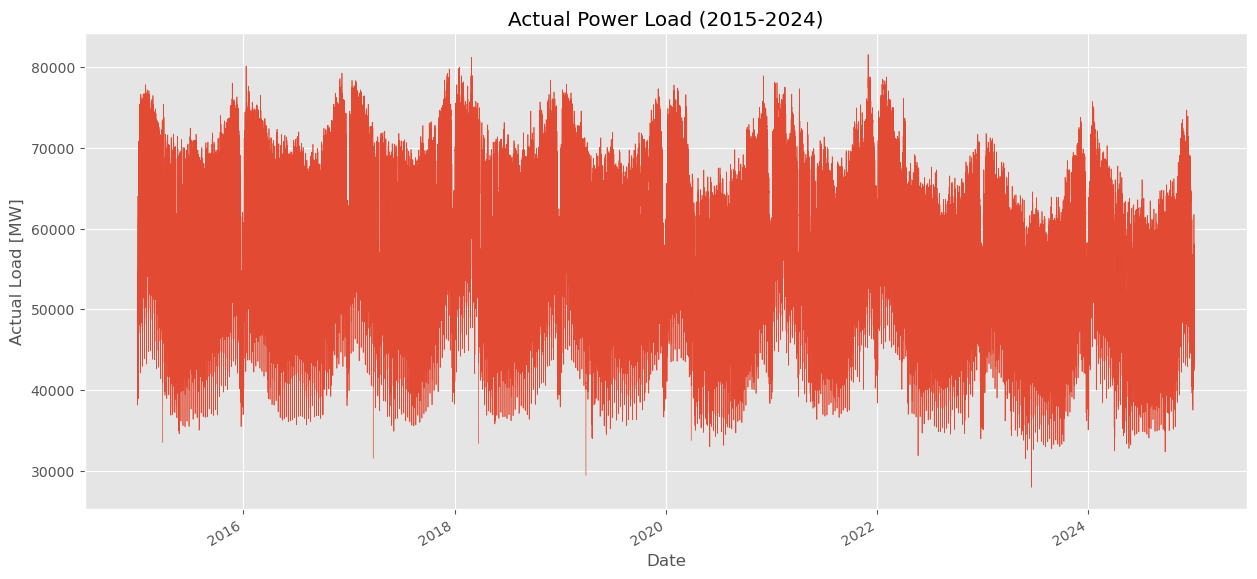


Plotting forecast vs. actual for a sample week in 2023


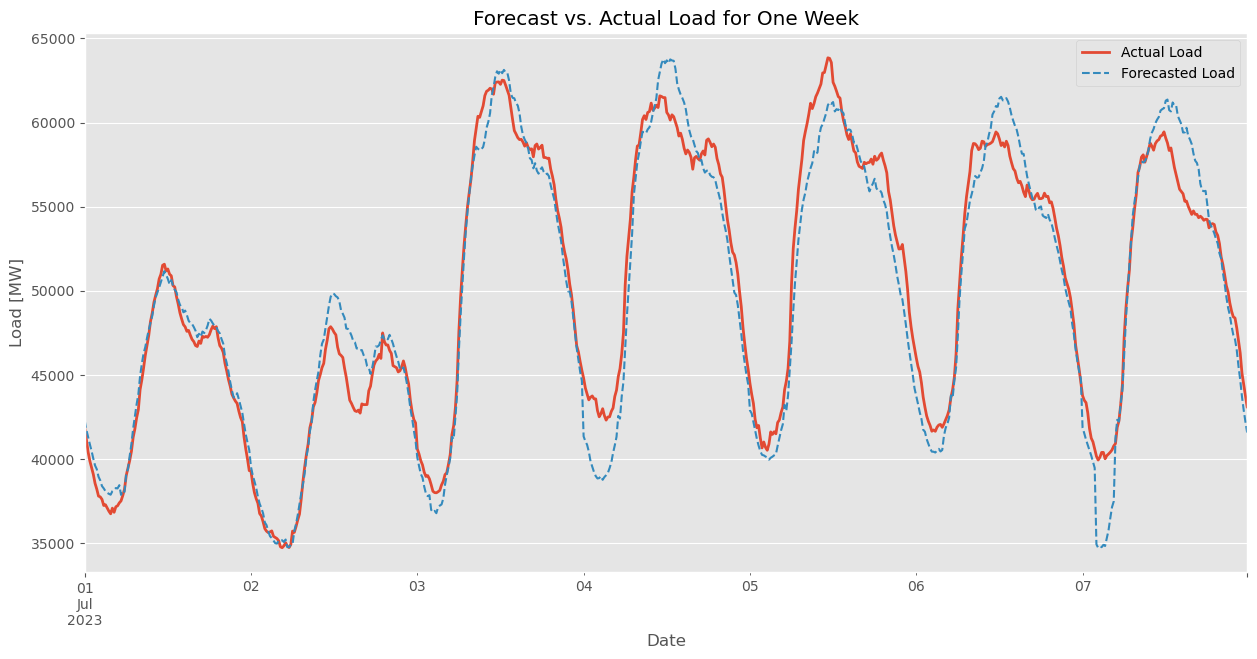


Plotting relationship between temperature and load


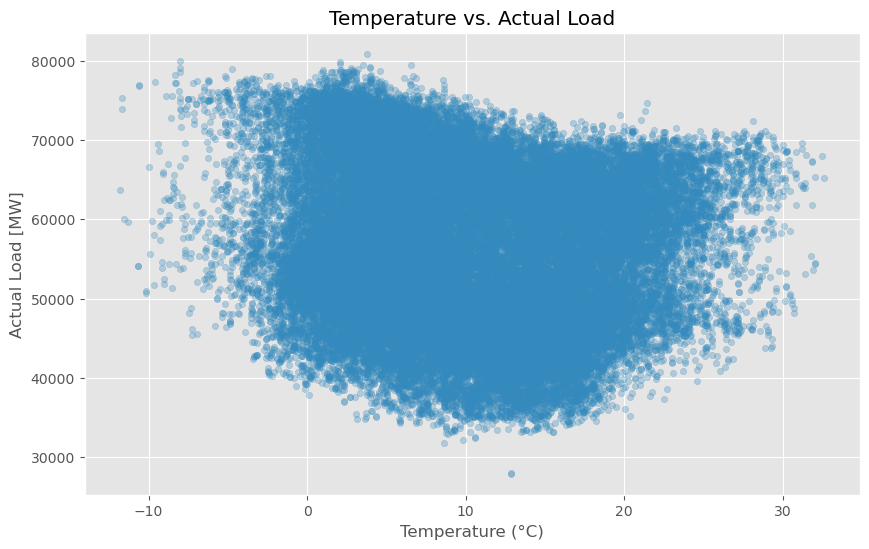


Calculating and plotting average load by hour of the day


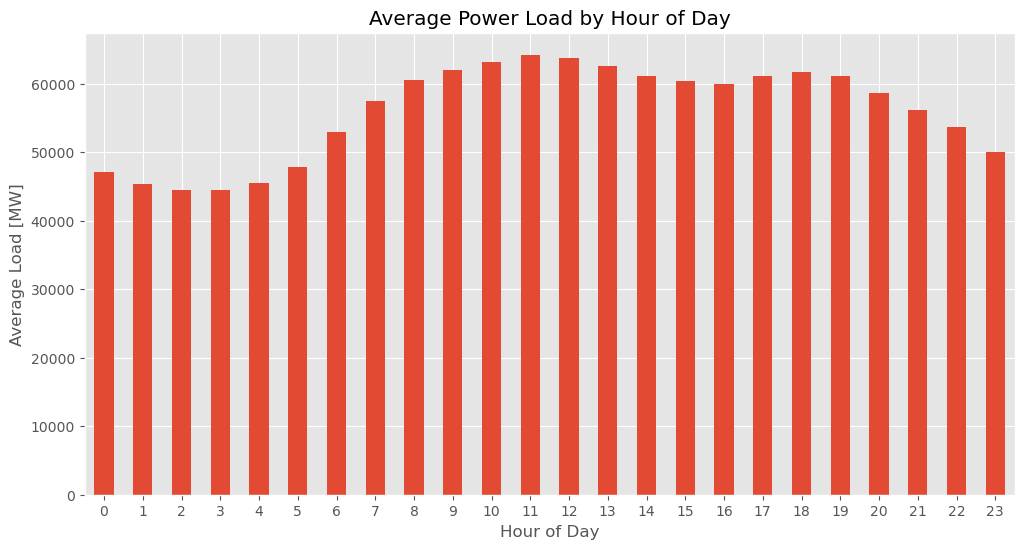


Calculating and plotting average load by day of the week


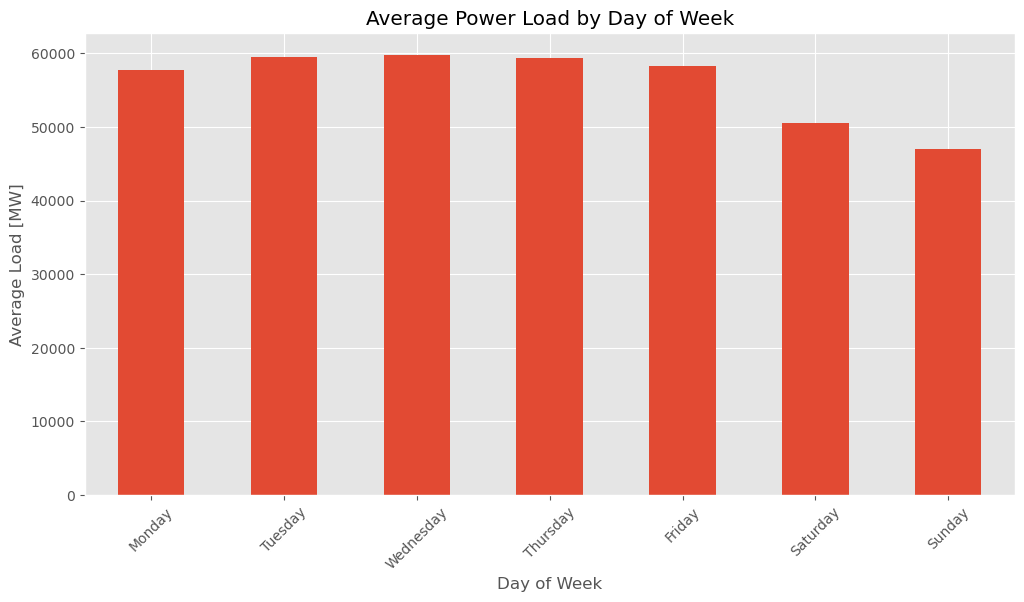

: 

In [ ]:
# Visualize the Data (Corrected)

# Set plot style for better aesthetics
plt.style.use('ggplot')

# 1. Plot Actual Load Over Time (Full Period)
print("Plotting actual load over the full time period")
fig, ax = plt.subplots(figsize=(15, 7))
df['actual_load'].plot(ax=ax, title='Actual Power Load (2015-2024)', lw=0.5)
ax.set_ylabel('Actual Load [MW]')
ax.set_xlabel('Date')
plt.show()


# 2. Plot Forecast vs. Actual (Sample Week)
print("\nPlotting forecast vs. actual for a sample week in 2023")
fig, ax = plt.subplots(figsize=(15, 7))
df_sample = df.loc['2023-07-01':'2023-07-07']
df_sample['actual_load'].plot(ax=ax, label='Actual Load', lw=2)
df_sample['forecast_load'].plot(ax=ax, label='Forecasted Load', ls='--')
ax.set_title('Forecast vs. Actual Load for One Week')
ax.set_ylabel('Load [MW]')
ax.set_xlabel('Date')
ax.legend()
plt.show()


# 3. Scatter Plot: Temperature vs. Load
print("\nPlotting relationship between temperature and load")
fig, ax = plt.subplots(figsize=(10, 6))
# Using a sample of 50000 points to make the plot render faster
df.sample(50000).plot.scatter(x='temperature', y='actual_load', alpha=0.3, ax=ax)
ax.set_title('Temperature vs. Actual Load')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Actual Load [MW]')
plt.show()


# 4. Average Load by Hour of Day (Daily Pattern)
print("\nCalculating and plotting average load by hour of the day")
fig, ax = plt.subplots(figsize=(12, 6))
df.groupby(df.index.hour)['actual_load'].mean().plot(kind='bar', ax=ax)
ax.set_title('Average Power Load by Hour of Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Load [MW]')
plt.xticks(rotation=0)
plt.show()


# 5. Average Load by Day of Week (Weekly Pattern)
print("\nCalculating and plotting average load by day of the week")
fig, ax = plt.subplots(figsize=(12, 6))
df.groupby(df.index.day_name())['actual_load'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', ax=ax)
ax.set_title('Average Power Load by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Load [MW]')
plt.xticks(rotation=45)
plt.show()